## **Mô tả ứng dụng: Thay đổi kích thước ảnh bằng Seam Carving**

**- Input**: một tấm ảnh RGB có định dạng *.pnm 

**- Output**: tấm ảnh này được thu hẹp chiều rộng mà không làm biến dạng các đối tượng quan trọng

**- Ý nghĩa thực tế của ứng dụng**:
- Tạo ra các phiên bản với các kích thước khác nhau của cùng một tấm ảnh để hiển
thị trên các thiết bị khác nhau (máy tính, điện thoại, ...)

**- Lý do cần tăng tốc**: Ứng dụng này chạy chậm khi cài đặt tuần tự
- Ví dụ: Độ phức tạp khi tìm seam ít quan trọng nhất: `O(width x height)` và ta cần thực hiện nhiều lần bước này đến khi đạt được số lượng seam cần xóa nhất định.

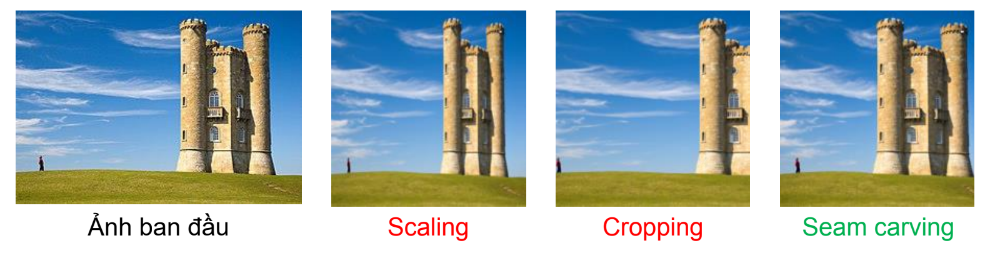

## **Các hàm hỗ trợ**

In [ ]:
# Đoạn code Python để hiển thị file ảnh pnm ở notebook
# Ví dụ để hiển thị file "img.pnm", ở dòng cuối của code cell
# bạn gõ (không cần dấu ! đằng trước): show_pnm('img.pnm')
# LƯU Ý: bạn phải chạy cell này một lần thì mới gọi được hàm show_pnm
from PIL import Image
import numpy as np
def show_pnm(file_name):
  with open(file_name, 'r') as f:
    vals = f.read().split()
  w = int(vals[1])
  h = int(vals[2])
  if vals[0] == 'P2': # Grayscale
    pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w))
  elif vals[0] == 'P3': # RGB
    pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w, 3))
  else:
    return None
  
  return Image.fromarray(pixels)

# Đoạn code Python để hiển thị file chứa ma trận ở notebook
# (một dòng của ma trận ứng với một dòng trong file, 
# các phần tử trên mỗi dòng được cách nhau bởi khoảng trắng) 
# Ví dụ để hiển thị file "pixel_importance.txt", ở dòng cuối của code cell
# bạn gõ: show_matrix('pixel_important.txt')
def show_matrix(matrix_file):
  m = np.loadtxt(matrix_file)
  m = m + m.min()
  m = m / m.max()
  m = m * 255
  m = m.astype(np.uint8)
  return Image.fromarray(m)

In [ ]:
from numba import cuda
major, minor = cuda.get_current_device().compute_capability
print(f'GPU compute capability: {major}.{minor}')

GPU compute capability: 7.5


In [ ]:
#Kiểm tra thông tin GPU
!nvidia-smi

Sat Jan  7 12:34:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    28W /  70W |    102MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/MyDrive/CK'

/content/drive/MyDrive/CK


## **Cài đặt tuần tự**

#### **Thiết kế**

Ta thực hiện các bước sau đây đến khi xóa được số seam mong muốn.

**Bước 1: Chuyển ảnh input RGB sang grayscale**
- Input: Mảng (`width * height`) chứa giá trị của ảnh ở dạng RGB có kiểu dữ liệu uchar3 *
- Output: Mảng (`width * height`) chứa giá trị của ảnh sau khi đã chuyển sang dạng grayscale, có kiểu dữ liệu int *
- Công thức chuyển đổi ứng với mỗi pixel: 0.299 * red + 0.587 * green + 0.114 * blue

**Bước 2: Tính độ quan trọng của mỗi pixels bằng phương pháp edge detection**
- Input: Mảng (`width * height`) chứa giá trị của ảnh ở dạng grayscale có kiểu dữ liệu int *
- Output: Mảng (`width * height`) chứa độ quan trọng của từng pixel tương ứng, có kiểu dữ liệu int *
- Phương pháp edge detection:
 + Phát hiện ảnh theo chiều x (1): thực hiện convolution giữa ảnh grayscale với bộ lọc x-Sobel
 + Phát hiện ảnh theo chiều y (2): thực hiện convolution giữa ảnh grayscale với bộ lọc y-Sobel
 + Độ quan trọng của mỗi pixel = abs(kết quả tương ứng của (1)) + abs(kết quả tương ứng của (2))

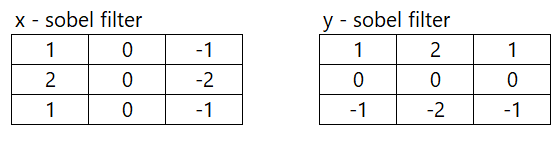

**Bước 3: Tính độ quan trọng của mỗi seam**
- Input: Mảng (`width * height`) chứa độ quan trọng của mỗi pixel
- Output: 
  + Mảng energySeams (`width * height`) chứa độ quan trọng của seam tính tới từng vị trí.
  + Mảng positions (`width * height`) chứa vị trí của phần tử tiếp theo trong seam.
- Ta thực hiện tính từ dưới lên:
  + Hàng dưới cùng là độ quan trọng của các pixel tương ứng.
  + Các hàng còn lại, mỗi phần tử bằng tổng của độ quan trọng tại đó và phần tử ít quan trọng liền kề ở hàng dưới (i-1,i,i+1)
  + Positions sẽ lưu vị trí của phần tử ít quan trọng nhất liền kề đó
  

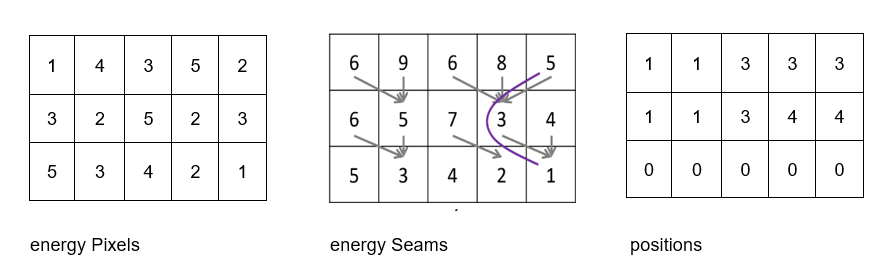

**Bước 4: Tìm seam ít quan trọng nhất**
- Input: Mảng energySeams và positions (`width * height`) thu được từ bước 3.
- Output: Mảng minSeam (`height`) chứa vị trí các pixel trên mỗi hàng của seam ít quan trọng nhất.
- Thực hiện:
  + Duyệt hàng trên cùng để tìm seam ít quan trọng nhất.
  + Duyệt positions để tìm các phần tử của seam này và lưu vào minSeam.

Ở ví dụ trên ta tìm được minSeam = {4,3,4}

**Bước 5: Xóa seam ít quan trọng nhất vừa tìm được ra khỏi ảnh**
- Input: 
  + Tấm ảnh đầu vào RGB (*.pnm) ban đầu (`width * height`)
  + Seam ít quan trọng nhất trong ảnh (`height`)
- Output: Mảng (`(width - 1) * height`) là ảnh sau khi đã xóa các pixel nằm trên seam ít quan trọng nhất.
- Thực hiện duyệt từng phần tử trên mảng input theo từng hàng:
  + Phần tử thuộc minSeam: bỏ qua.
  + Nếu nằm sau minSeam (chỉ số cột lớn hơn) được gán bằng giá trị pixels bên trái tương ứng trong mảng input.
  + Nếu nằm trước minSeam (chỉ số cột nhỏ hơn) được gán bằng giá trị pixel tương ứng trong mảng input.

Sau cùng, gán mảng input bằng mảng ouput vừa tìm được, giảm width đi 1 đơn vị. Và tiếp tục vòng lặp. 

#### **Thử nghiệm và đánh giá**

In [ ]:
#Biên dịch
!nvcc -arch=sm_{major}{minor} sequential.cu -o sequential

Câu lệnh thực thi sẽ có 3 hoặc 4 tham số đầu vào theo thứ tự:
- Tham số 1: đường dẫn đến file thực thi
- Tham số 2: đường dẫn đến file ảnh đầu vào
- Tham số 3: tên file ảnh đầu ra được ghép thêm _host.pnm ở cuối
- Tham số 4 (tùy chọn): số lượng seam muốn xóa. Nếu không truyền vào, giá trị mặc định là 50.

In [ ]:
!./sequential in.pnm out 100

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 byte
SMEM per SM: 65536 byte
SMEM per block: 49152 byte
****************************
Image size (width x height): 640 x 434

Successful!
Output image size: 540 x 434
Processing time (use host - convert image to grayscale): 221.489777 ms
Processing time (use host - detect edge): 4145.249023 ms
Processing time (use host - find a seam): 840.794678 ms
Processing time (use host - remove seam): 111.833618 ms
Processing time (use host - in total): 5325.866699 ms


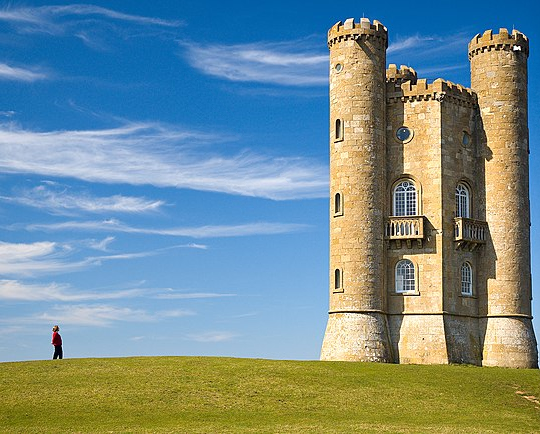

In [ ]:
#Hiển thị ảnh kết quả
show_pnm('out_host.pnm')

**Nhận xét:** Phiên bản tự cài đặt của nhóm cho kết quả khá tốt, gần như tương đương so với ví dụ gốc được nêu. Tuy nhiên thời gian thực thi lớn.

## **Cài đặt song song - version 1**

#### **Phân tích**
Sau khi thực hiện đo thời gian chạy tuần tự trên CPU của từng bước, nhóm nhận thấy thời gian chạy của các hàm đều lớn và có khả năng song song hóa vì các công việc độc lập nhau đặc biệt là ở bước detect edge. Nên nhóm quyết định song song hóa các hàm:
- Chuyển ảnh RGB thành grayscale
- Tính độ quan trọng của pixels bằng phương pháp edge detection
- Tính độ quan trọng của các seams và vị trí các pixels thuộc các seams
- Xóa một seam ra khỏi mảng

#### **Thiết kế**

Các bước chung cho tất cả các hàm:
- Cấp phát bộ nhớ cho các mảng input, output
- Sao chép dữ liệu từ host sang device

**Hàm 1: Chuyển ảnh input RGB sang grayscale**
- Mỗi thread sẽ thực hiện tính giá trị grayscale cho một pixel với công thức như cài đặt tuần tự.

**Hàm 2: Tính độ quan trong của pixels bằng phương pháp egde detection**
- Mỗi thread sẽ thực hiện phép nhân tích chập lần lượt với bộ lọc x-Sobel và y-Sobel. Sau đó tính tổng trị tuyệt đối của 2 giá trị trên.

**Hàm 3: Tính độ quan trọng và lưu vị trí các seams**
- Nhóm thực hiện song song theo từng hàng và dùng câu lệnh __synchthreads()__ bởi vì để tính toán giá trị ở hàng hiện tại cần sử dụng đến giá trị ở hàng kế tiếp.
- Duyệt các hàng theo thứ tự giảm dần, xét từng phần tử ta sẽ chọn phần tử liền kề ở hàng kế tiếp có giá trị nhỏ nhất và cộng với giá trị của phần tử hiện tại, lưu lại vị trí của phần tử nhỏ nhất này.



**Hàm 4: Xóa một seam ra khỏi mảng**
- Mỗi thread sẽ thực hiện gán giá trị từ input sang output với quy tắc giống như ở cài đặt tuần tự.



#### **Thử nghiệm và đánh giá**
Thử nghiệm trên nhiều numstep và blockSize khác nhau sẽ được trình bày thêm ở phần cuối.

In [ ]:
#Biên dịch
!nvcc -arch=sm_{major}{minor} parallel-v1.cu -o parallel-v1

Câu lệnh thực thi sẽ có 3, 4 hoặc 6 tham số đầu vào với 4 tham số đầu giống với câu lệnh thực thi code tuần tự.
- Tham số 5, 6 (tùy chọn): kích thước block theo chiều x và y, mặc định là 32x32

In [ ]:
# blockSize mặc định
!./parallel-v1 'in.pnm' out 100

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 byte
SMEM per SM: 65536 byte
SMEM per block: 49152 byte
****************************
Image size (width x height): 640 x 434

Kernel:
block size 32x32, grid size 20x14
Successful!
Output image size: 540 x 434
Processing time: 114.942909 ms


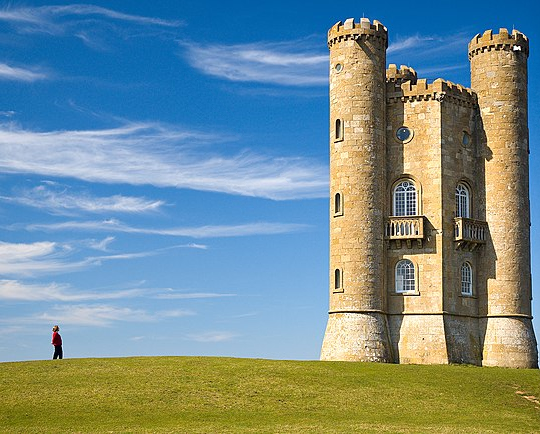

In [ ]:
show_pnm('out_device_v1.pnm')

**Nhận xét:** Các hàm kernel chạy song song trên GPU có thời gian thực thi nhanh hơn nhiều so với chạy tuần tự trên CPU.

## **Tối ưu hóa cài đặt song song lần 1 - version 2**

#### **Phân tích**

Ở phiên bản song song đầu tiên, các hàm cần truy xuất dữ liệu GMEM lưu ở DRAM dẫn đến thời gian truy xuất chậm. Do đó nhóm quyết định giảm thời gian truy xuất dữ liệu bằng cách:

- Sử dụng SMEM vì dữ liệu tại SMEM được lưu ở phạm vi block.
- Sử dụng CMEM vì ta cần áp dụng bộ lọc Sobel đề tìm ra độ quan trọng của từng pixel trong ảnh và giá trị bộ lọc này là không thay đổi.

#### **Thiết kế**

Nhóm tiến hành tối ưu hóa phiên bản cài đặt song song trên GPU theo hướng:
- Sử dụng SMEM ở các hàm kernel: 
  - Tính độ quan trọng của pixels.
  - Hàm xóa một seam khỏi ảnh.
- Sử dụng CMEM: lưu giá trị của 2 bộ lọc x-Sobel và y-Sobel được sử dụng trong hàm tính độ quan trọng của các pixels.

#### **Thử nghiệm và đánh giá**

Thử nghiệm trên nhiều numstep và blockSize khác nhau sẽ được trình bày thêm ở phần cuối.

In [ ]:
!nvcc -arch=sm_{major}{minor} parallel-v2.cu -o parallel-v2

Câu lệnh thực thi tương tự như ở phiên bản 1.

In [ ]:
# blockSize mặc định
!./parallel-v2 'in.pnm' out 100

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 byte
SMEM per SM: 65536 byte
SMEM per block: 49152 byte
****************************
Image size (width x height): 640 x 434

Kernel:
block size 32x32, grid size 20x14
Successful!
Output image size: 540 x 434
Processing time: 109.927551 ms


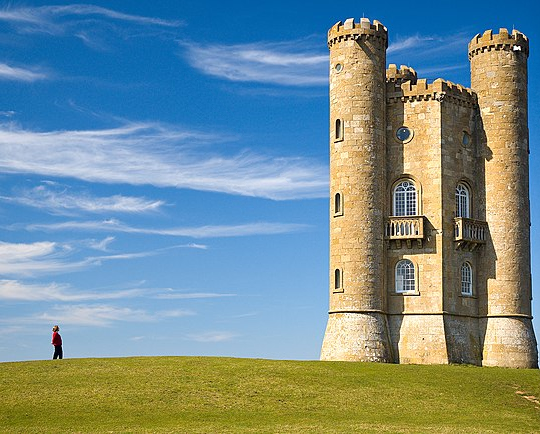

In [ ]:
show_pnm('out_device_v2.pnm')

**Nhận xét:** Thời gian thực thi của hàm tính độ quan trọng của pixels giảm nhưng ngược lại ở hàm xóa seam tăng nên khó kết luận khi so sánh về thời gian thực thi giữa phiên bản song song 2 với phiên bản song song đầu tiên.

Lý do: có thể do bank conflict làm cho việc sử dụng SMEM chưa đạt hiệu quả cao. 

## **Tối ưu hóa cài đặt song song lần 2 - version 3**

#### **Phân tích**
Nhận thấy ở bước tìm seam ít quan trọng nhất vì vẫn còn chạy tuần tự nên thời gian thực thi còn lớn, nên nhóm chọn thực hiện reduce để tính phần này trên GPU.
  

#### **Thiết kế**

Nhóm tiến hành tối ưu hóa ở phiên bản này bằng cách: 
- Song song hoá bước tìm ra vị trí seam ít quan trọng nhất thực hiện tương tự như bài toán reduce và sử dụng SMEM lưu dữ liệu. 
- Hàm kernel tìm vị trí nhỏ nhất của mảng dữ liệu theo từng block song song và từ các giá trị nhỏ nhất ở các block, nhóm thực hiện code tuần tự tìm ra giá trị cuối cùng.

In [ ]:
!nvcc -arch=sm_{major}{minor} parallel-v3.cu -o parallel-v3

In [ ]:
!./parallel-v3 'in.pnm' out 100

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 byte
SMEM per SM: 65536 byte
SMEM per block: 49152 byte
****************************
Image size (width x height): 640 x 434

Kernel:
block size 32x32, grid size 20x14
Successful!
Output image size: 540 x 434
Processing time: 114.856606 ms


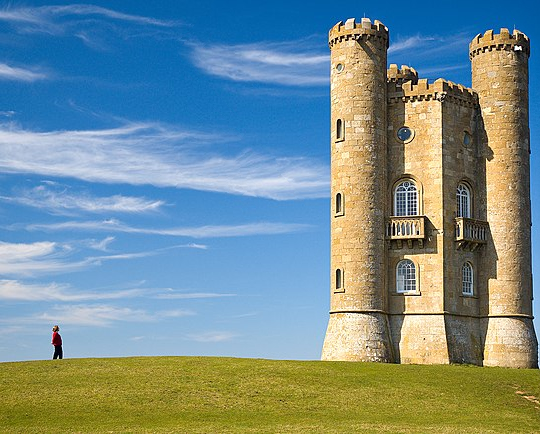

In [ ]:
show_pnm('out_device_v3.pnm')

**Nhận xét:** 
- Thời gian chạy chậm hơn. 

- Lý do: có thể do bank conflict, blockSize nhỏ nên việc lưu dữ liệu từ GMEM vào SMEM và truy cập từ SMEM có thể chậm hơn. Ngoài ra có thể do có thêm bước chạy tuần tự để tìm ra kết quả nhỏ nhất trong mảng các giá trị min của các block.

- BlockSize nhỏ 16x16 không thể thực thi với numstep lớn.
- Không thực sự hiệu quả đối với cải tiến này 

## **Thử nghiệm và đánh giá chung**

Thử nghiệm trên 2 ảnh input dạng pnm và với blocksize 16x16 và 32x32.

**Ảnh 1 (width x height): 640x340**

In [ ]:
!nvcc -arch=sm_{major}{minor} all.cu -o all

In [ ]:
# blockSize = 16x16
!./all 'in.pnm' out 100 16 16

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 byte
SMEM per SM: 65536 byte
SMEM per block: 49152 byte
****************************
Image size (width x height): 640 x 434


Seam Carving by host
Successful!
Output image size: 540 x 434
Processing time (use host - convert image to grayscale): 223.437881 ms
Processing time (use host - detect edge): 4151.008301 ms
Processing time (use host - find a seam): 840.191040 ms
Processing time (use host - remove seam): 117.840149 ms
Processing time (use host - in total): 5338.859375 ms

Seam Carving by device version 1
Kernel:
block size 16x16, grid size 40x28
Successful!
Output image size: 540 x 434
Processing time: 110.094627 ms

Seam Carving by device version 2
Kernel:
block size 16x16, grid size 40x28
Successful!
Output image size: 540 x 434
Processing time: 107.910110 ms

Seam Carving by device version 3
Kernel:
block size 16x16, grid size 

In [ ]:
# blockSize = 32x32 
!./all 'in.pnm' out 100

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 byte
SMEM per SM: 65536 byte
SMEM per block: 49152 byte
****************************
Image size (width x height): 640 x 434


Seam Carving by host
Successful!
Output image size: 540 x 434
Processing time (use host - convert image to grayscale): 226.307663 ms
Processing time (use host - detect edge): 4126.212402 ms
Processing time (use host - find a seam): 844.165344 ms
Processing time (use host - remove seam): 114.529427 ms
Processing time (use host - in total): 5317.569336 ms

Seam Carving by device version 1
Kernel:
block size 32x32, grid size 20x14
Successful!
Output image size: 540 x 434
Processing time: 109.898239 ms

Seam Carving by device version 2
Kernel:
block size 32x32, grid size 20x14
Successful!
Output image size: 540 x 434
Processing time: 109.503746 ms

Seam Carving by device version 3
Kernel:
block size 32x32, grid size 

In [ ]:
# blockSize = 16x16
!./all 'in.pnm' out 400 16 16

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 byte
SMEM per SM: 65536 byte
SMEM per block: 49152 byte
****************************
Image size (width x height): 640 x 434


Seam Carving by host
Successful!
Output image size: 240 x 434
Processing time (use host - convert image to grayscale): 655.791321 ms
Processing time (use host - detect edge): 12121.455078 ms
Processing time (use host - find a seam): 2469.263916 ms
Processing time (use host - remove seam): 339.390289 ms
Processing time (use host - in total): 15604.238281 ms

Seam Carving by device version 1
Kernel:
block size 16x16, grid size 40x28
Successful!
Output image size: 240 x 434
Processing time: 344.092926 ms

Seam Carving by device version 2
Kernel:
block size 16x16, grid size 40x28
Successful!
Output image size: 240 x 434
Processing time: 302.016174 ms

Seam Carving by device version 3
Kernel:
block size 16x16, grid si

In [ ]:
# blockSize = 32x32
!./all 'in.pnm' out 400

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 byte
SMEM per SM: 65536 byte
SMEM per block: 49152 byte
****************************
Image size (width x height): 640 x 434


Seam Carving by host
Successful!
Output image size: 240 x 434
Processing time (use host - convert image to grayscale): 697.579041 ms
Processing time (use host - detect edge): 13228.223633 ms
Processing time (use host - find a seam): 2697.543457 ms
Processing time (use host - remove seam): 383.600708 ms
Processing time (use host - in total): 17026.298828 ms

Seam Carving by device version 1
Kernel:
block size 32x32, grid size 20x14
Successful!
Output image size: 240 x 434
Processing time: 344.064972 ms

Seam Carving by device version 2
Kernel:
block size 32x32, grid size 20x14
Successful!
Output image size: 240 x 434
Processing time: 307.697327 ms

Seam Carving by device version 3
Kernel:
block size 32x32, grid si

**Ảnh 2 (width x height): 400x400**

In [ ]:
# blockSize = 16x16
!./all 'in2.pnm' out2 50 16 16

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 byte
SMEM per SM: 65536 byte
SMEM per block: 49152 byte
****************************
Image size (width x height): 400 x 400


Seam Carving by host
Successful!
Output image size: 350 x 400
Processing time (use host - convert image to grayscale): 63.718113 ms
Processing time (use host - detect edge): 1209.239014 ms
Processing time (use host - find a seam): 243.498199 ms
Processing time (use host - remove seam): 33.596546 ms
Processing time (use host - in total): 1553.558960 ms

Seam Carving by device version 1
Kernel:
block size 16x16, grid size 25x25
Successful!
Output image size: 350 x 400
Processing time: 37.706017 ms

Seam Carving by device version 2
Kernel:
block size 16x16, grid size 25x25
Successful!
Output image size: 350 x 400
Processing time: 37.046593 ms

Seam Carving by device version 3
Kernel:
block size 16x16, grid size 25x2

In [ ]:
# blockSize = 32x32
!./all 'in2.pnm' out2 200

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 byte
SMEM per SM: 65536 byte
SMEM per block: 49152 byte
****************************
Image size (width x height): 400 x 400


Seam Carving by host
Successful!
Output image size: 200 x 400
Processing time (use host - convert image to grayscale): 208.228500 ms
Processing time (use host - detect edge): 3840.675781 ms
Processing time (use host - find a seam): 788.844299 ms
Processing time (use host - remove seam): 109.903923 ms
Processing time (use host - in total): 4957.080078 ms

Seam Carving by device version 1
Kernel:
block size 32x32, grid size 13x13
Successful!
Output image size: 200 x 400
Processing time: 128.246521 ms

Seam Carving by device version 2
Kernel:
block size 32x32, grid size 13x13
Successful!
Output image size: 200 x 400
Processing time: 124.769630 ms

Seam Carving by device version 3
Kernel:
block size 32x32, grid size 

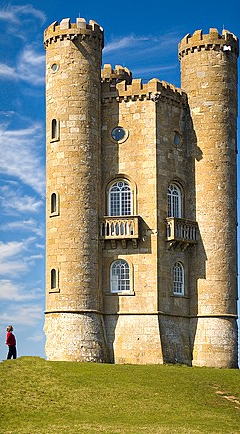

In [ ]:
show_pnm('out_host.pnm')

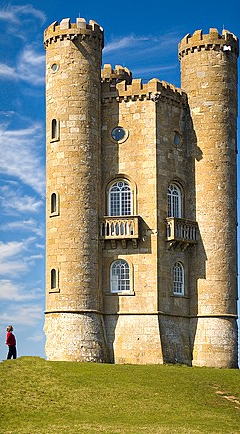

In [ ]:
show_pnm('out_device_v1.pnm')

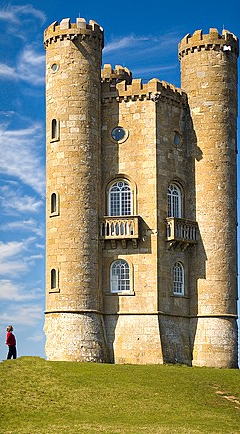

In [ ]:
show_pnm('out_device_v2.pnm')

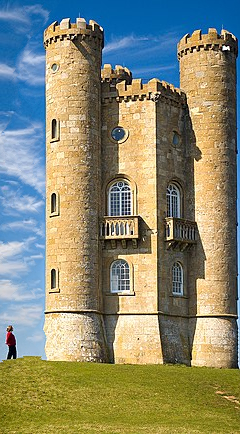

In [ ]:
show_pnm('out_device_v3.pnm')

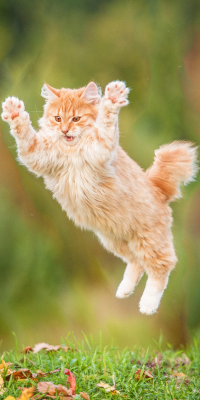

In [ ]:
show_pnm('out2_host.pnm')

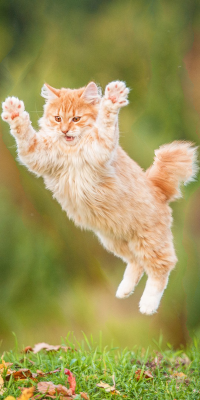

In [ ]:
show_pnm('out2_device_v1.pnm')

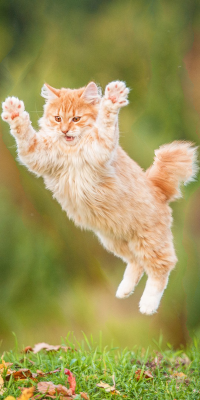

In [ ]:
show_pnm('out2_device_v2.pnm')

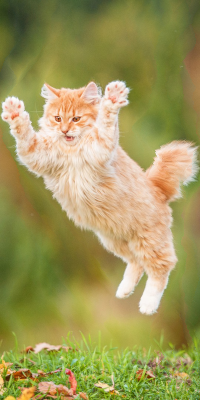

In [ ]:
show_pnm('out2_device_v3.pnm')

**Bảng kết quả**

Bảng ghi lại kết quả tương đối vì giữa các lần chạy, thời gian thực thi cũng khác nhau và phụ thuộc vào GPU. 


|   | Block Size | Input Size | Output Size | Host (ms) | Device 1 time | Device 1 error | Device 2 (ms) | Device 2 error | Device 3 (ms) | Device 3 error |
|-------|------------|-------------|-----------|---------------|----------------|---------------|----------------|---------------|----------------|----------------|
| Ảnh 1 | 16x16 |640 x 434  | 540 x 434   | 5608.77  | 116.19      | 0.000000       | 116.21      | 0.000000       | 118.75       | 8.918518       |
| Ảnh 1 | 32x32 |640 x 434  | 540 x 434   | 5751.32  | 115.38      | 0.000000       | 113.61      | 0.000000       | 112.08       | 9.047654       |
| Ảnh 1 | 32x32 | 640 x 434  | 240 x 434   | 17688.67  | 353.55      | 0.000000       | 316.64     | 0.000000       | 329.44       | 6.932514       |
| Ảnh 2 | 32x32 | 400 x 400  | 200 x 400   | 5245.18  | 135.11       | 0.035300       | 131.69        | 0.035300       | 129.49        | 2.483362       |


#### **Nhận xét chung**

- Các phiên bản song song có thời gian thực thi nhanh hơn nhiều lần so với phiên bản tuần tự.
- Tốc độ thực thi của các phiên bản song song không chênh lệch đáng kể. Tuy nhiên khi so sánh với kết quả tương đối, trong nhiều trường hợp ta thấy các phiên bản tối ưu thực thi nhanh hơn. 
- Kích thước blockSize 32x32 thực thi tốt hơn trong nhiều trường hợp. 
- Các phiên bản song song không chạy được với các blockSize lớn dẫn đến số lần đi đến GMEM để lấy dữ liệu lớn và thời gian chép dữ liệu từ GMEM về SMEM có thể lớn hơn.
- Đối với các blocksize lớn khó thực thi khi ở phiên bản thứ 3

## **Tài liệu tham khảo**

- Tài liệu trong môn Lập trình song song 
- [Wikipedia, Seam Carving](https://en.wikipedia.org/wiki/Seam_carving)
- Seam Carving for Content-Aware Image Resizing by Shai Avidan and Ariel Shami
- Optimization of a single seam removal using a GPU by Rok Cešnovar, Patricio Buliˇc, and Tomaž Dobravec
- Fast JND-Based Video Carving with GPU Acceleration for Real-Time Video Retargeting by Chen-Kuo Chiang, Shu-Fan Wang, Yi-Ling Chen, and Shang-Hong Lai
